# Predicting Stocks using LSTM & GRU

In [0]:
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, GRU

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Using TensorFlow backend.


In [0]:
def stock(code, years_back):
  end = datetime.now()
  start = datetime(end.year-years_back, end.month, end.day)

  code = '{}.SI'.format(code)
  df = web.DataReader(code, 'yahoo', start, end)
  
  return df


def plot_validate(model, loss_acc):
  '''Plot model accuracy or loss for both train and test validation per epoch
  model = fitted model
  loss_acc = input 'loss' or 'acc' to plot respective graph
  '''
  history = model.history.history

  if loss_acc == 'loss':
      axis_title = 'loss'
      title = 'Loss'
      epoch = len(history['loss'])
  elif loss_acc == 'acc':
      axis_title = 'acc'
      title = 'Accuracy'
      epoch = len(history['loss'])

  plt.figure(figsize=(15,4))
  plt.plot(history[axis_title])
  plt.plot(history['val_' + axis_title])
  plt.title('Model ' + title)
  plt.ylabel(title)
  plt.xlabel('Epoch')

  plt.grid(b=True, which='major')
  plt.minorticks_on()
  plt.grid(b=True, which='minor', alpha=0.2)

  plt.legend(['Train', 'Test'])
  plt.show()


In [0]:
df = stock('S68', 10)
df['change_per'] = df['Close'].pct_change()
df['change'] = df['change_per'].apply(lambda x: 1 if x > 0 else 0)

df1 = df[:2400]
df2 = df[2400:]

print('total: ',df.shape)
print('train: ',df1.shape)
print('test: ',df2.shape)

total:  (2508, 8)
train:  (2400, 8)
test:  (108, 8)


In [0]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,change_per,change
Date,,,,,,,,
2009-07-28,8.87,8.62,8.79,8.78,6964000.0,5.958014,NaN,0
2009-07-29,8.77,8.33,8.77,8.52,7814000.0,5.781581,-0.029613,0
2009-07-30,8.63,8.37,8.50,8.63,6435000.0,5.856227,0.012911,1
2009-07-31,8.78,8.64,8.66,8.72,6151000.0,5.917300,0.010429,1
2009-08-03,8.77,8.62,8.69,8.76,3837000.0,5.944442,0.004587,1


# Preprocess Time-Series

In [0]:
X_train = df1[['High','Low','Open','Volume']].values
y_train = df1['Close'].values
X_test = df2[['High','Low','Open','Volume']].values
y_test = df2['Close'].values

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

time_steps = 10
sampling_rate = 1
num_sample = 1200

data = TimeseriesGenerator(X_train, y_train,
                           length=time_steps, 
                           sampling_rate=sampling_rate,
                           batch_size=num_sample)
X_train = data[0][0]
y_train = data[0][1]

data = TimeseriesGenerator(X_test, y_test,
                           length=time_steps, 
                           sampling_rate=sampling_rate,
                           batch_size=num_sample)
X_test = data[0][0]
y_test = data[0][1]

In [0]:
def lstm(X_train, y_train, X_test, y_test, classes, epoch, batch, verbose, dropout):
  
  model = Sequential()
  
  # return sequences refer to all the outputs of the memory cells, True if next layer is LSTM
  model.add(LSTM(150, dropout=dropout, recurrent_dropout=0.2, return_sequences=False, input_shape=X_train.shape[1:]))
#   model.add(LSTM(100, dropout=dropout, recurrent_dropout=0.2, return_sequences=False))
  
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='rmsprop',
              loss='mse')

  model.fit(X_train, y_train,
            batch_size=batch,
            epochs= epoch,
            verbose=verbose,
            validation_data=(X_test, y_test))

  return model

In [0]:
classes = 1
epoch = 10
batch = 200
verbose = 0
dropout = 0.2

model = lstm(X_train, y_train, X_test, y_test, classes, epoch, batch, verbose, dropout)

W0728 12:53:10.939361 140526042519424 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0728 12:53:11.645472 140526042519424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Plotting

## Loss

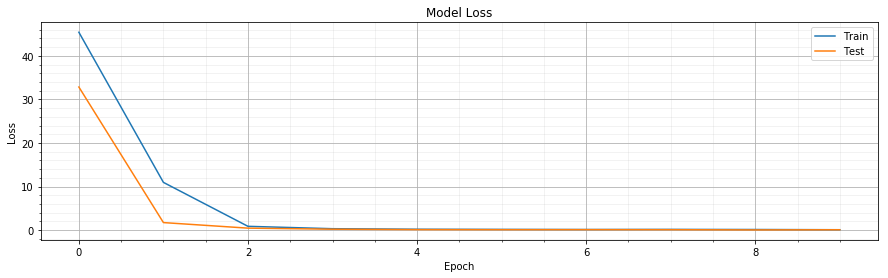

In [0]:
# plot_validate(model, 'acc')
plot_validate(model, 'loss')

In [0]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

## Train-Test vs Prediction

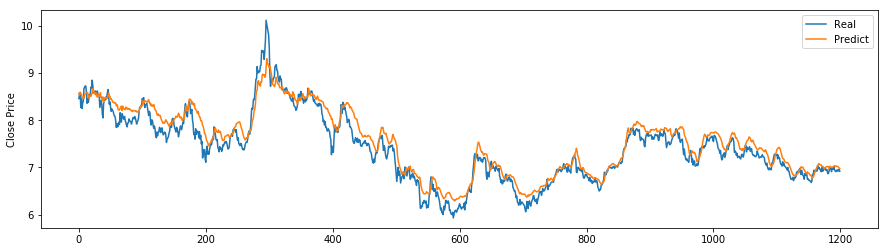

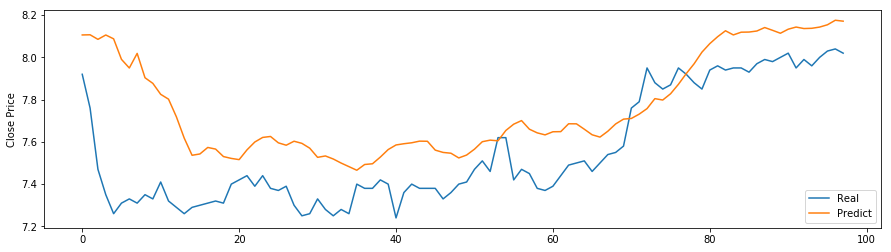

In [0]:
for real, predict in [(y_train, predict_train),(y_test, predict_test)]:
  plt.figure(figsize=(15,4))
  plt.plot(real)
  plt.plot(predict)
  plt.ylabel('Close Price');
  plt.legend(['Real', 'Predict']);